# Guide to producing figures

In this notebook we will discuss how the main figures (2 and 3) for the standard problem are produced. As noted in the [README](README.md), these can also be produced by running `make figures` in the source directories. This is an alternative, annotated description of the analysis to help users understand the important steps. For all figures here we will use the cached **OOMMF** data.

Firstly we import all required tools, if you recieve an `ImportError` after running the following cell then you may not have `matplotlib` or `numpy` installed. We also define a function `fft`, which generates the frequency spectrum using  a fast Fourier transform (using the `numpy`, `fft` routin). 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def fft(mx, dt=5e-12):
    """ FFT of the data at dt """
    n = len(mx)
    freq = np.fft.fftfreq(n, dt)

    ft_mx = np.fft.fft(mx)

    ft_abs = np.abs(ft_mx)
    ft_phase = np.angle(ft_mx)

    return freq, ft_abs, ft_phase

## Producing Figure 2

We will be using the cached file `dynamic_txyz.txt` which contains the output on the magnetisation as a function of time for *dynamic* stage of the standard problem as produced by `OOMMF`. We begin by reading in this cached data and extracting the y component of the magnetisation. 

In [2]:
txyzFileLoc = "./src/oommf_scripts/dynamic_txyz.txt"

data = np.loadtxt(txyzFileLoc)

ts = data[:, 0]
my = data[:, 2]

Following this, we generate the frequency spectrum using the previously defined `fft` function. This returns the frequency `freq`, the absolute magnitude of amplitude `ft_abs`, and the `phase`. 

In [3]:
dt = ts[1]-ts[0]
freq, ft_abs, phase = fft(my, dt)

The following code generates Figure 2, using the data. For help with the plotting routines please refer to the [matplotlib documentation](http://matplotlib.org/).

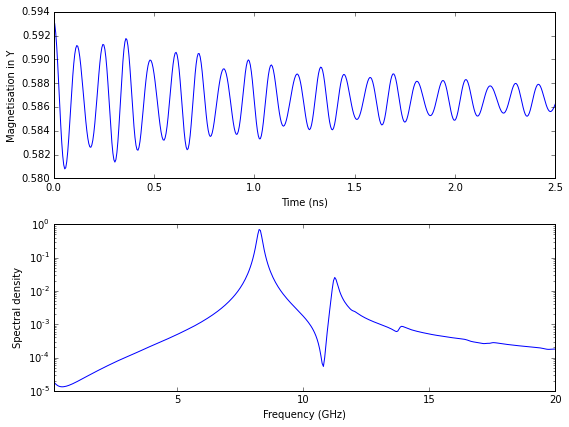

In [4]:

ft_power = ft_abs**2
length = len(freq)/2

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(ts*1e9, my, label='Real')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Magnetisation in Y')
ax.set_xlim([0, 2.5])

ax = fig.add_subplot(2, 1, 2)
ax.plot(freq[0:length]*1e-9, ft_power[0:length], '-', label='Real')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Spectral density')
ax.set_xlim([0.1, 20])
ax.set_ylim([1e-5, 1e-0])
ax.set_yscale('log')

plt.tight_layout()

## Producing Figure 3

Figure 3 compares the *spatially resolved* power spectrum, $S_{y}$, and the *spatially averaged* power spectrum, $\tilde{S}_y$, as defined in Eq. (5). To produce these figures we first generate the spatially averaged power spectrum: taking the y-magnetization data we use a function `spatial_fft` to save the data to `./src/oommf_scripts/mys_ft_abs.npy` and `./src/oommf_scripts/mys_ft_phase.npy`. Note that we produce the data for all three directions, but in the following only the `y` component is used (the others are used in generating figures (4) and (5)).

In [15]:
def spatial_fft(dataname):
    """ Spatially averaged FFT as defined in Eqn. (4) """
    ft_abs = []
    ft_phase = []

    mys = np.load(dataname)
    m, n = mys.shape

    for i in range(n):
        f, ft_a, ft_p = fft(mys[:, i])
        ft_abs.append(ft_a)
        ft_phase.append(ft_p)

    np.save(dataname[:-4]+'_ft_abs.npy', np.array(ft_abs))
    np.save(dataname[:-4]+'_ft_phase.npy', np.array(ft_phase))
    
spatial_fft("./src/oommf_scripts/mys.npy")

We now load the data: for the spatially resolved data this is the same file `./src/oommf_scripts/dynamic_txyz.txt` used in generating Figure 2, for the spatially averaged data this is the file `./src/oommf_scripts/mys_ft_abs.npy` produced in the previous cell.

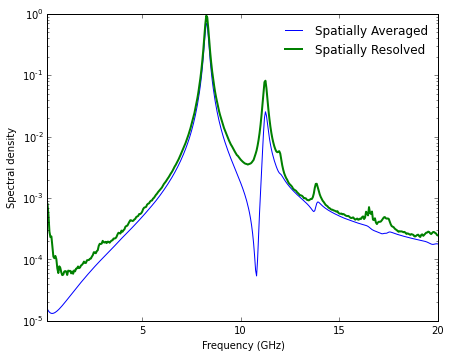

In [10]:
txyzFileLoc = "./src/oommf_scripts/dynamic_txyz.txt"
mys_ft_absLoc = "./src/oommf_scripts/mys_ft_abs.npy"
data = np.loadtxt(txyzFileLoc)

ts = data[:, 0]
my = data[:, 2]

dt = ts[1]-ts[0]

freq, ft_abs, phase = fft(my,  dt)
ft_power = ft_abs**2

length = len(freq)/2

mys = np.load(mys_ft_absLoc)
averaged = np.average(mys**2, axis=0)

fig = plt.figure(figsize=(7, 5.5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(freq[0:length]*1e-9, ft_power[0:length], label='Spatially Averaged')
ax.plot(freq[0:length]*1e-9, averaged[0:length], color="g", lw=2, label='Spatially Resolved')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Spectral density')
ax.set_xlim([0.2, 20])
ax.set_ylim([1e-5, 1e0])
ax.set_yscale('log')
ax.legend(frameon=False)
plt.show()